## Transit SNR Calculator

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
# Define constants and telescope parameters
r = (50.8/2)*(10**(-2)) # metres
rn = 7.10 # e-
T = 0.065
T_err = 0.003
D = 0.12 # e/pix/sec
gain = 1.28 # e-/ADU
lati = -42.4311
long = 147.2878
hght = 646 # m
hc = 1.9867*(10**(-16)) # J*nm

# Define some filter characteristics (all in nm) from Bessell 2005
i_bp = 123.0
i_eff = 743.9
q_i = 0.81
i_zpt = 22.22
i_zpt_er = 0.01
ki = 0.18
ki_er = 0.02

r_bp = 115.0
r_eff = 612.2
q_r = 0.92
r_zpt = 22.45
r_zpt_er = 0.01
kr = 0.20
kr_er = 0.02

g_bp = 128.0
g_eff = 463.9
q_g = 0.83
g_zpt = 22.55
g_zpt_er = 0.01
kg = 0.32
kg_er = 0.01

V_bp = 84.0
V_eff = 544.8
q_V = 0.91
V_zpt = 22.19
V_zpt_er = 0.01
kV = 0.24
kV_er = 0.01

B_bp = 89.0
B_eff = 436.1
q_B = 0.72
B_zpt = 21.61
B_zpt_er = 0.04
kB = 0.43
kB_er = 0.01

In [3]:
def get_fltrinfo(fltr):
    """
    Retrieves the zeropoint, effective wavelength, bandpass and quantum efficiency
    for a specific filter
    
    params:
    fltr - The desired filter
    """
    if fltr == 'i':
        zpt = i_zpt
        eff_wl = i_eff
        bp = i_bp
        q = q_i
        k = ki
    elif fltr == 'r':
        zpt = r_zpt
        eff_wl = r_eff
        bp = r_bp
        q = q_r 
        k = kr
    elif fltr == 'g':
        zpt = g_zpt
        eff_wl = g_eff
        bp = g_bp
        q = q_g 
        k = kg
    elif fltr == 'V':
        zpt = V_zpt
        eff_wl = V_eff
        bp = V_bp
        q = q_V 
        k = kV
    elif fltr == 'B':
        zpt = B_zpt
        eff_wl = B_eff
        bp = B_bp
        q = q_B
        k = kB
    else:
        print('Not a valid filter...')
           
    return zpt, eff_wl, bp, q, k

def calc_flux_density(mag, airmass, fltr):
    """
    A function to calculate the flux density of a point source given input mag and filter info.
    
    Params:
    mag - The magnitude in some filter
    Zpt - The magnitude zeropoint for desired filter

    
    Return:
    F - The flux density of the object
    """
    zpt, eff_wl, bp, q, k = get_fltrinfo(fltr)
    mag_cor = mag + k*airmass
    F = 10**((zpt-mag_cor)/2.5) # e/s/A/bp
    return F


def calc_E(F_obj, r, T, fltr):
    """
    A function to calculate the object signal rate of a point source given flux density 
    and telescope properties.
    
    Params:
    F_obj - The flux density of the object in a certain filter
    r - The radius of the telescope mirror
    T - The transmission efficiency of atmosphere, telescope and camera
    q - The quantum efficiency of the camera
    fltr - The desired filter (str)
    
    Return:
    E - The object signal rate
    """
    zpt, eff_wl, bp, q, k = get_fltrinfo(fltr)
    E = F_obj*(np.pi*(r**2))*T*q*bp # e/s
    return E

def calc_Fobj(E, r, T, fltr):
    """
    A function to calculate the object signal rate of a point source given flux density 
    and telescope properties.
    
    Params:
    E - The object signal rate
    r - The radius of the telescope mirror
    T - The transmission efficiency of atmosphere, telescope and camera
    q - The quantum efficiency of the camera
    fltr - The desired filter
    
    Return:
    F_obj - The flux density of the object in a certain filter
    """
    zpt, eff_wl, bp, q, k = get_fltrinfo(fltr)
    F_obj = E/(np.pi*(r**2)*T*q*bp*(eff_wl/hc))
    return F_obj

def calc_SNR(E, t, n_pix, R, D, rn):
    """
    Function to calculate the theoretical signal to noise ratio for the 50cm telescope
    
    params:
    E - The object signal rate
    t - The exposure time
    n_pix - The number of pixels for the aperture
    R - The sky background 
    D - The dark current 
    rn - The read noise 
    """
    SNR = E*t/np.sqrt((E*t)+n_pix*(R*t+D*t+rn**2))
    return SNR 

def calc_sky(moon_phase, fltr):
    """
    Calculate an approximate sky brightness rate in e/s/pix 
    
    params:
    moon_phase - The moon phase in deg
    fltr - The desired filter
    
    return:
    
    The sky background rate in e/s/pix
    """
    # Just do medians for now
    if fltr == 'i':
        R = 13.9
    elif fltr == 'r':
        R = 10.2
    elif fltr == 'g':
        R = 1.7
    elif fltr == 'V':
        R = 3.5
    elif fltr == 'B':
        R = 0.7
    return R

In [6]:
def calc_transit_snr(mag, depth, t, n_pix, R, fltr, tau):
    """
    A function to calculate the SNR of a transit from a simple approximation of no red noise
    
    n - Number of data points during the transit
    
    sigma - The white noise error (photon stats)
    
    depth - Transit depth
    """
    E = calc_E(calc_flux_density(mag, 1.5, fltr), r, T, fltr)
    
    depth_mag = 2.5*np.log10(1+depth)
    
    sigma = 2.5*np.log10(1+(1/calc_SNR(E, t, n_pix, R, D, rn)))
    
    snr = (depth_mag/sigma)*np.sqrt(tau/t)
    
    return snr

In [7]:
def calc_transit_depth(mag, snr, t, n_pix, R, fltr, tau):
    """
    A function to calculate the SNR of a transit from a simple approximation of no red noise
    
    n - Number of data points during the transit
    
    sigma - The white noise error (photon stats)
    
    depth - Transit depth
    """
    E = calc_E(calc_flux_density(mag, 1.5, fltr), r, T, fltr)
    
    sigma = 2.5*np.log10(1+(1/calc_SNR(E, t, n_pix, R, D, rn)))
    
    depth_mag = (snr*sigma)/np.sqrt(tau/t)
    
    depth = (10**(depth_mag/2.5)) - 1
    
    return depth

# Plots

### For V

In [8]:
t_vec = np.arange(3, 180, 0.1)
mag_vec = np.arange(10, 15.1, 0.1)
duration_vec = np.arange(0.5, 4.1, 0.1)
depth_vec = np.arange(0.0005, 0.02, 0.0001)

X, Y = np.meshgrid(t_vec, mag_vec)
snr_vec_10ppt = calc_transit_snr(Y, 0.01, X, 8,calc_sky(0, 'V'), 'V', 2*3600)
snr_vec_5ppt = calc_transit_snr(Y, 0.005, X, 8,calc_sky(0, 'V'), 'V', 2*3600)
snr_vec_1ppt = calc_transit_snr(Y, 0.001, X, 8,calc_sky(0, 'V'), 'V', 2*3600)
snr_vec_05ppt = calc_transit_snr(Y, 0.0005, X,8, calc_sky(0, 'V'), 'V', 2*3600)

X2, Y2 = np.meshgrid(duration_vec, mag_vec)
snr_vec_30s = calc_transit_snr(Y2, 0.005, 30, 8, calc_sky(0, 'V'), 'V', X2*3600)
snr_vec_60s = calc_transit_snr(Y2, 0.005, 60, 8, calc_sky(0, 'V'), 'V', X2*3600)
snr_vec_120s = calc_transit_snr(Y2, 0.005, 120, 8, calc_sky(0, 'V'), 'V', X2*3600)
snr_vec_180s = calc_transit_snr(Y2, 0.005, 180, 8, calc_sky(0, 'V'), 'V', X2*3600)

X3, Y3 = np.meshgrid(mag_vec, depth_vec)
snr_vec_1h = calc_transit_snr(X3, Y3, 60, 8, calc_sky(0, 'V'), 'V', 3600)
snr_vec_2h = calc_transit_snr(X3, Y3, 60, 8, calc_sky(0, 'V'), 'V', 2*3600)
snr_vec_3h = calc_transit_snr(X3, Y3, 60, 8, calc_sky(0, 'V'), 'V', 3*3600)
snr_vec_4h = calc_transit_snr(X3, Y3, 60, 8, calc_sky(0, 'V'), 'V', 4*3600)

X_crit_1h, Y_crit_1h = np.meshgrid(mag_vec, calc_transit_depth(mag_vec, 10.0, 60, 8, calc_sky(0, 'V'), 'V', 3600))

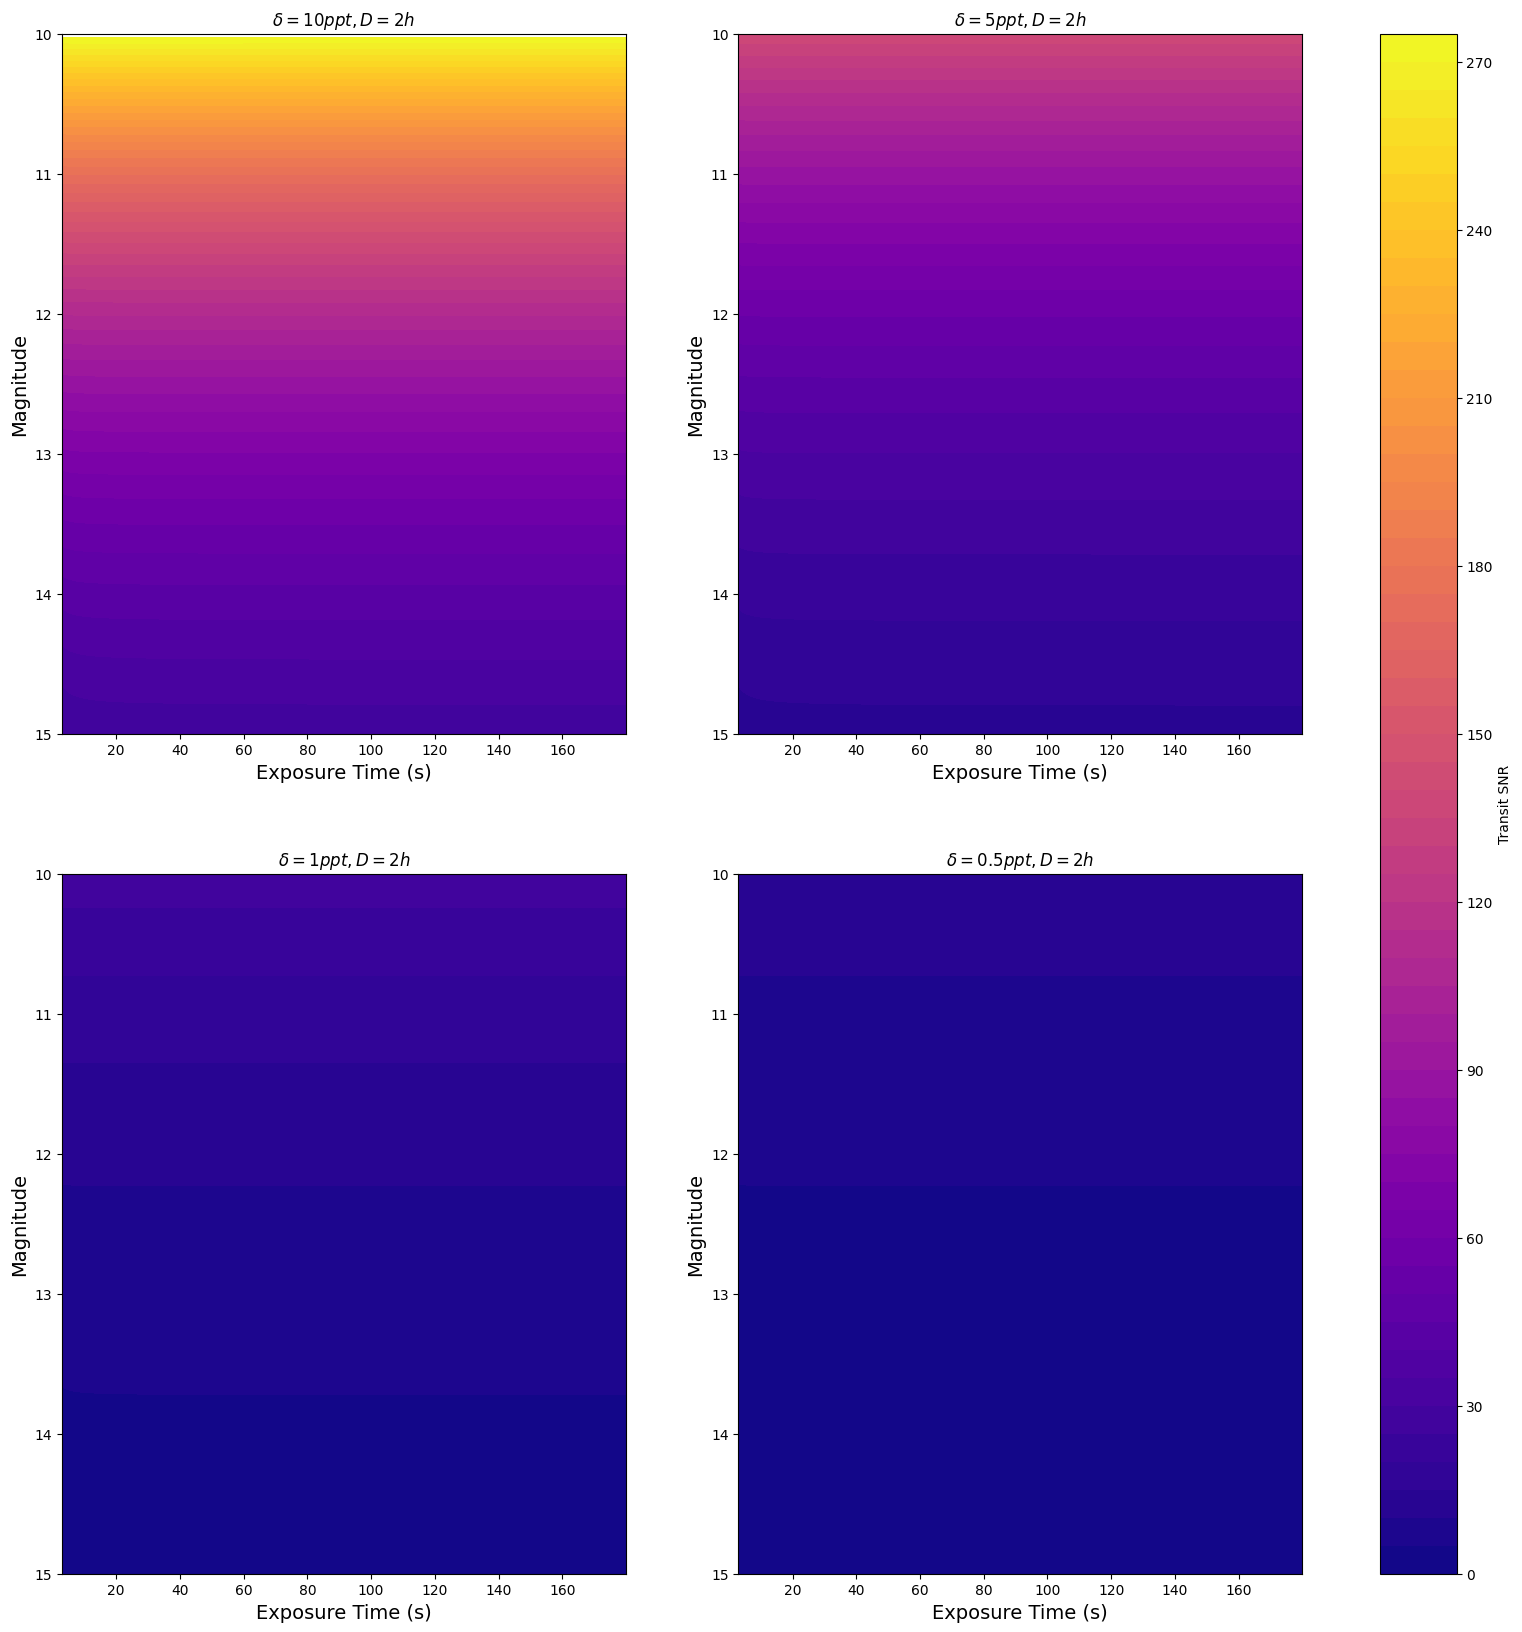

In [11]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

maxsnr = np.max([snr_vec_10ppt,snr_vec_05ppt, snr_vec_1ppt, snr_vec_5ppt])
#minsnr = np.min(snr_vec_05ppt)
#norm = colors.Normalize(vmin=0, vmax=maxsnr)

colour_levels = np.arange(0, maxsnr, 5)

im = ax[0,0].contourf(X, Y, snr_vec_10ppt, cmap='plasma', levels = colour_levels)
ax[0,0].set_title('$ \delta = 10 ppt, D = 2 h $')

ax[1,0].contourf(X, Y, snr_vec_1ppt, cmap='plasma', levels = colour_levels)
ax[1,0].set_title('$ \delta = 1 ppt, D = 2 h $')

ax[0,1].contourf(X,Y, snr_vec_5ppt, cmap='plasma', levels = colour_levels)
ax[0,1].set_title('$ \delta = 5 ppt, D = 2 h $')

ax[1,1].contourf(X,Y, snr_vec_05ppt, cmap='plasma', levels = colour_levels)
ax[1,1].set_title('$ \delta = 0.5 ppt, D = 2 h $')


for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('Magnitude', fontsize = 14)
        ax[i,j].set_xlabel('Exposure Time (s)', fontsize = 14)
        ax[i,j].set_ylim(15,10)
        

#fig.subplots_adjust(right=0.8)
fig.colorbar(im, ax=ax, label = 'Transit SNR')
#fig.suptitle('Harlingten 50cm - Transit SNR', fontsize = 14, fontweight = 'bold')
#plt.savefig('TransitSNR_MagExp')
#plt.tight_layout()

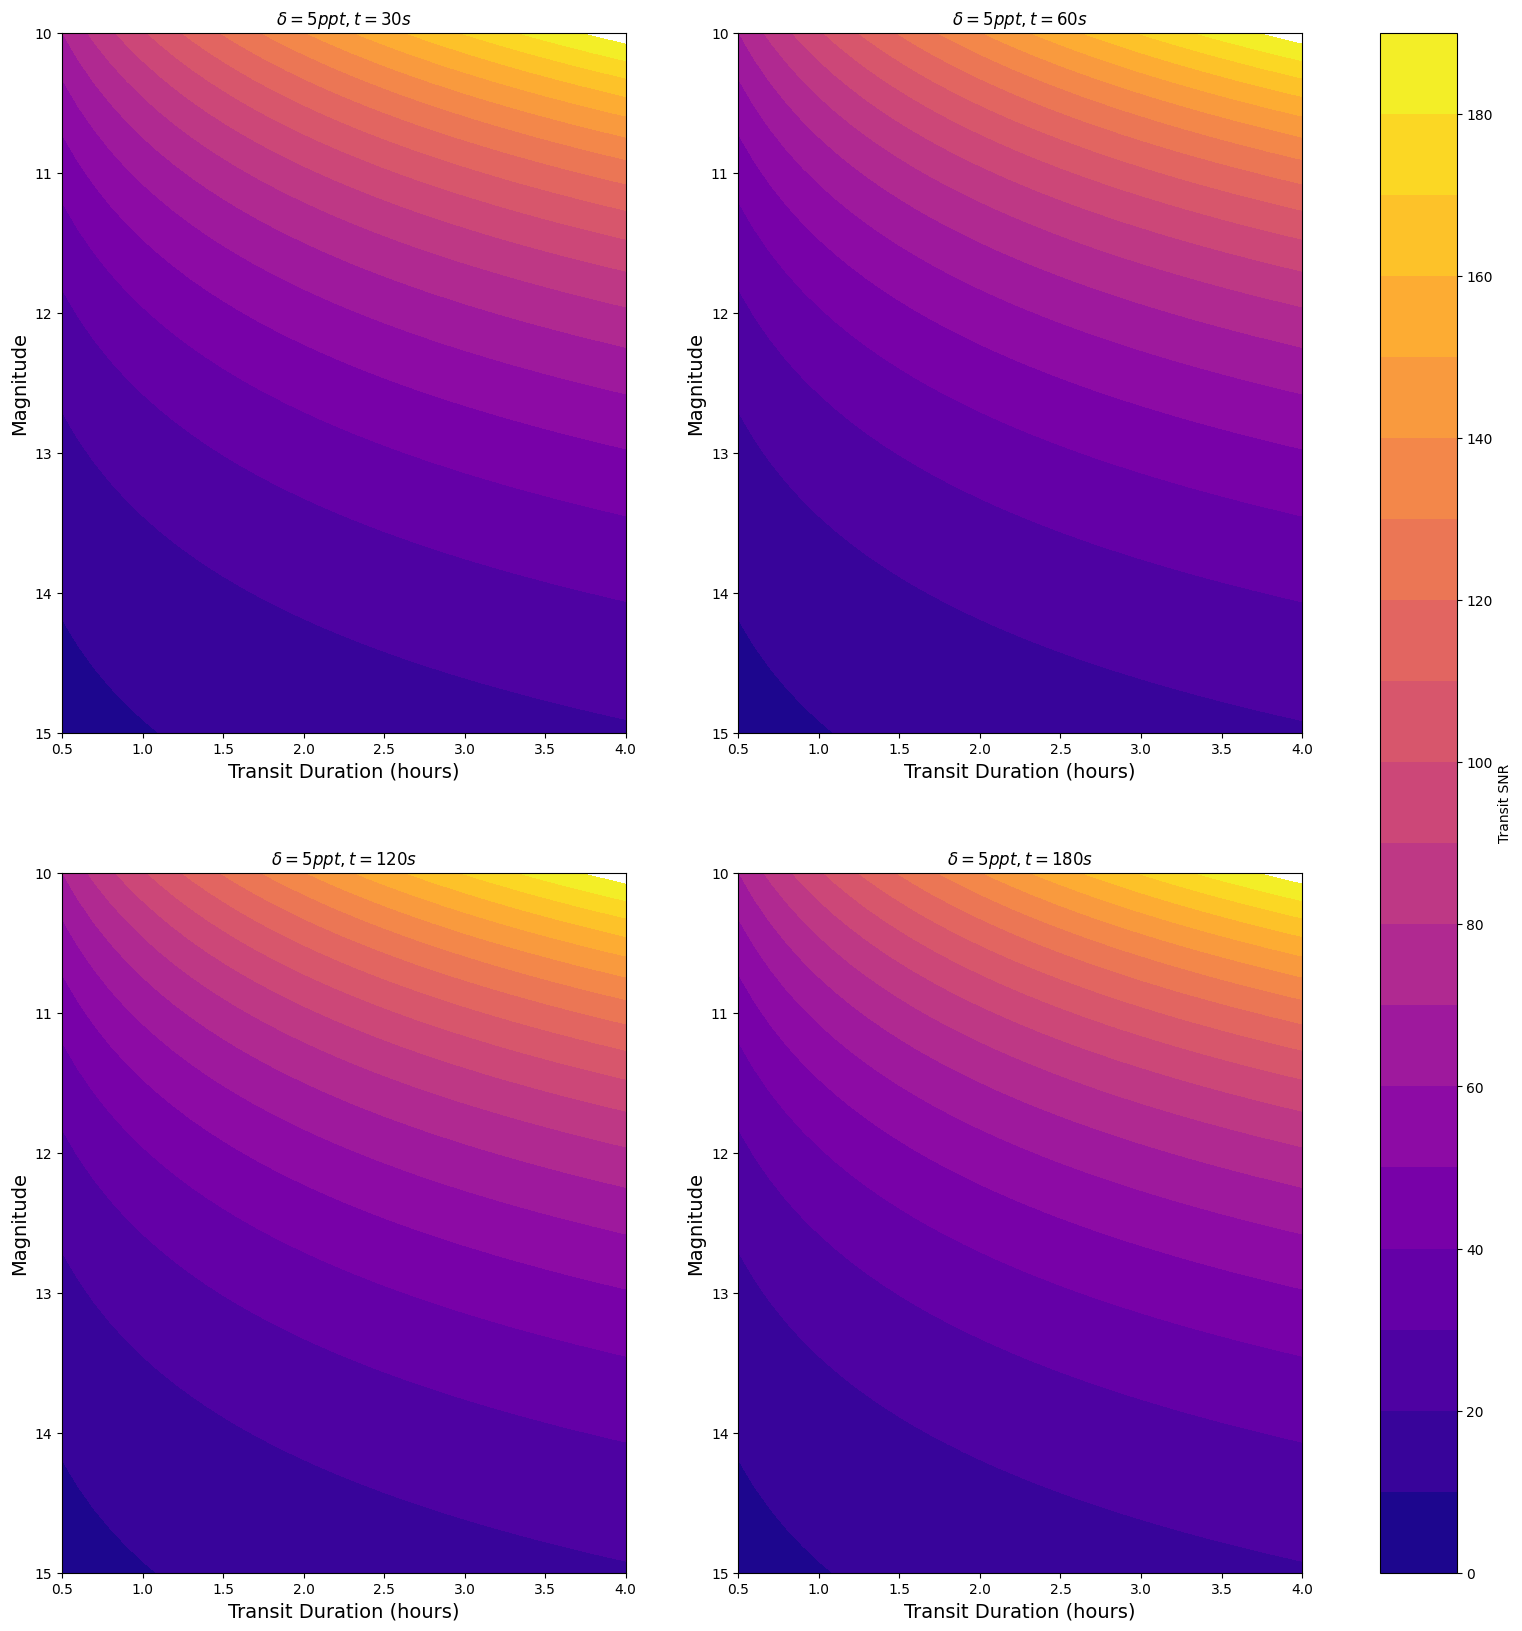

In [12]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

maxsnr = np.max([snr_vec_30s,snr_vec_60s, snr_vec_120s, snr_vec_180s])
colour_levels = np.arange(0, maxsnr, 10)


ax[0,0].contourf(X2, Y2, snr_vec_30s, cmap='plasma', levels = colour_levels)
ax[0,0].set_title('$ \delta = 5 ppt , t = 30 s $')

im = ax[0,1].contourf(X2, Y2, snr_vec_60s, cmap='plasma', levels = colour_levels)
ax[0,1].set_title('$ \delta = 5 ppt , t = 60 s $')

ax[1,0].contourf(X2,Y2, snr_vec_120s, cmap='plasma', levels = colour_levels)
ax[1,0].set_title('$ \delta = 5 ppt , t = 120 s $')

ax[1,1].contourf(X2,Y2, snr_vec_180s, cmap='plasma', levels = colour_levels)
ax[1,1].set_title('$ \delta = 5 ppt , t = 180 s $')

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('Magnitude', fontsize = 14)
        ax[i,j].set_xlabel('Transit Duration (hours)', fontsize = 14)
        ax[i,j].set_ylim(15,10)
        
#fig.subplots_adjust(right=0.8)
fig.colorbar(im, ax=ax, label = 'Transit SNR')
#fig.suptitle('Harlingten 50cm - Transit SNR', fontsize = 14, fontweight = 'bold')
#plt.savefig('TransitSNR_MagDur')

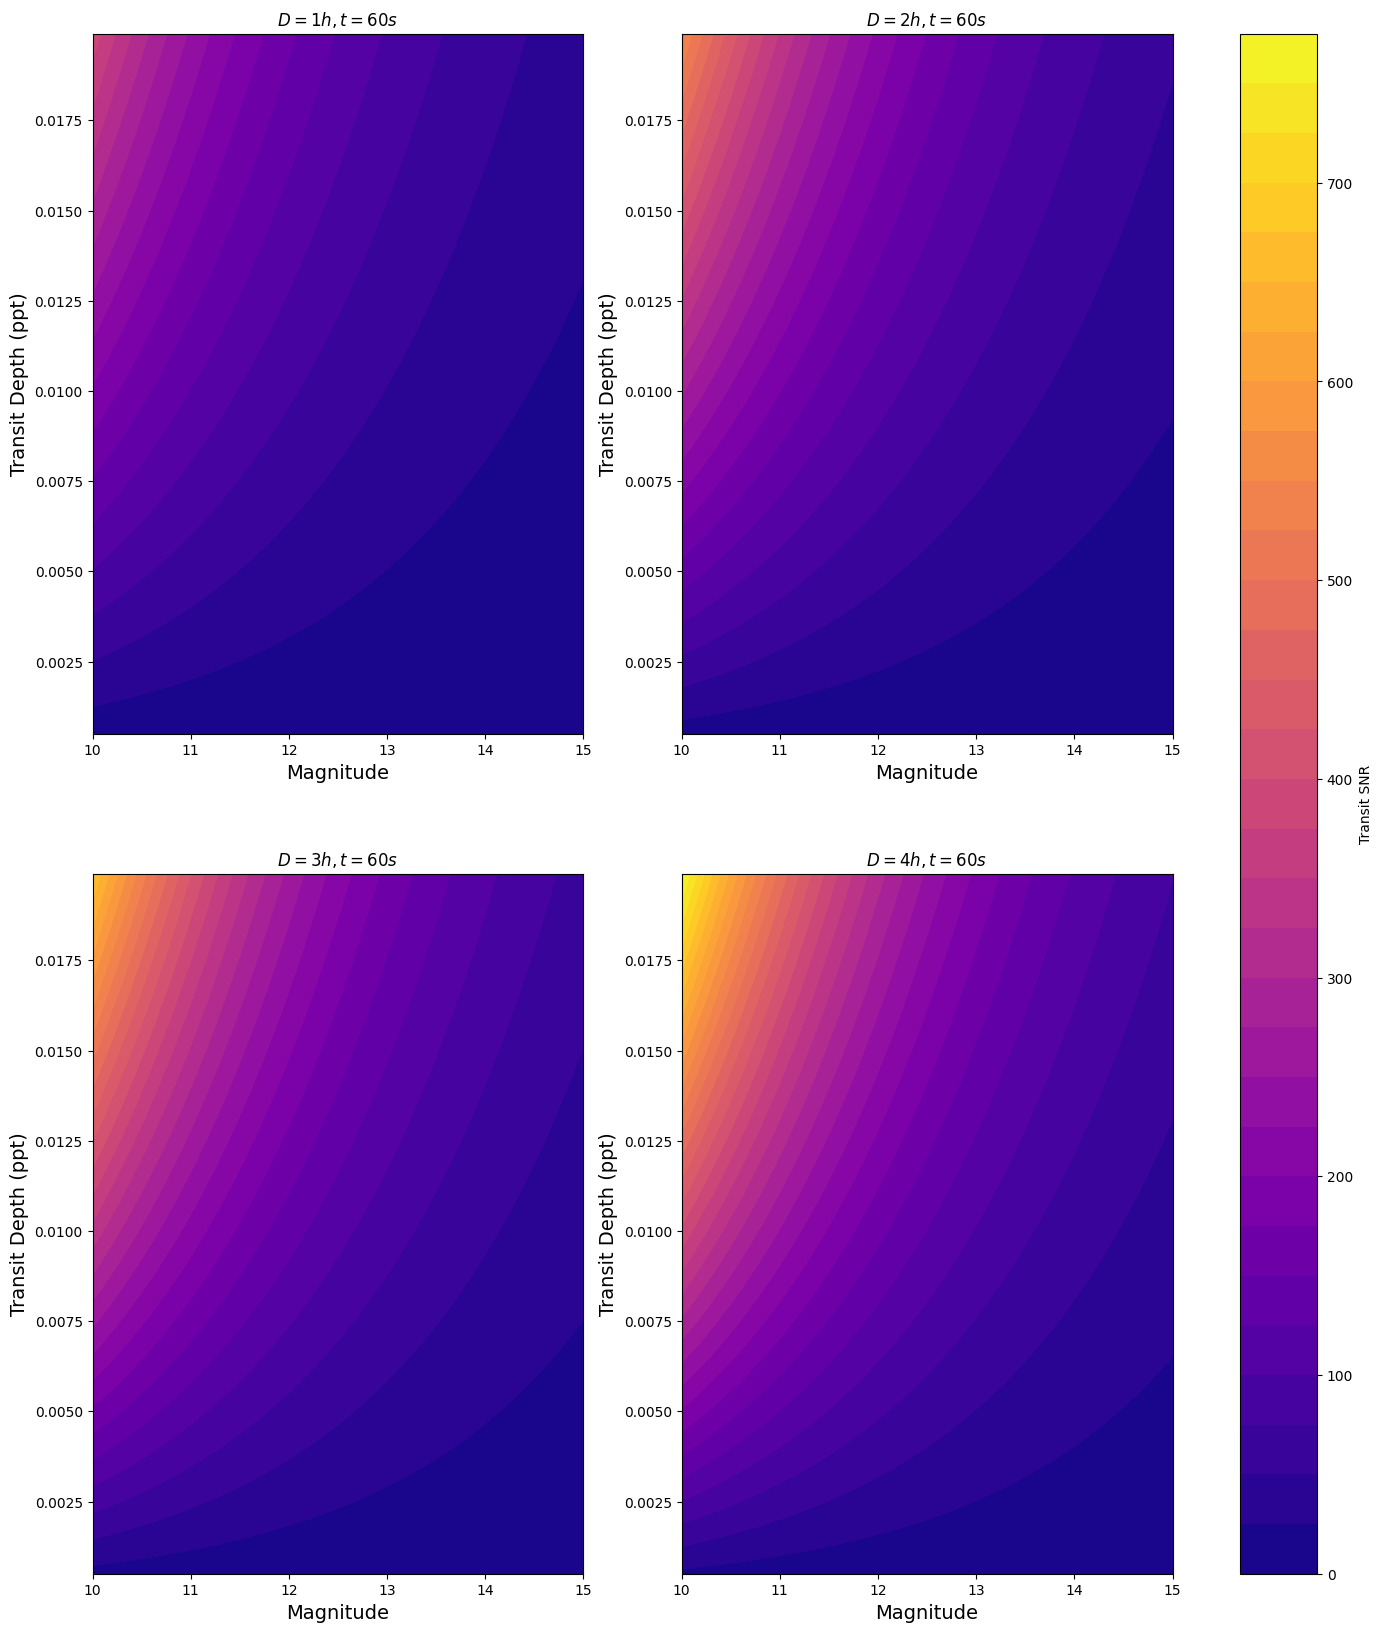

In [13]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

maxsnr = np.max([snr_vec_1h,snr_vec_2h, snr_vec_3h, snr_vec_4h])

color_levels = np.arange(0, maxsnr, 25)

ax[0,0].contourf(X3, Y3, snr_vec_1h, cmap='plasma', levels = color_levels)
ax[0,0].set_title('$ D = 1 h, t = 60 s$')

ax[0,1].contourf(X3, Y3, snr_vec_2h, cmap='plasma', levels = color_levels)
ax[0,1].set_title('$ D = 2 h, t = 60 s$')

ax[1,0].contourf(X3,Y3, snr_vec_3h,cmap='plasma', levels = color_levels)
ax[1,0].set_title('$ D = 3 h, t = 60 s$')

im = ax[1,1].contourf(X3,Y3, snr_vec_4h, cmap='plasma', levels = color_levels)
ax[1,1].set_title('$ D = 4 h, t = 60 s$')


for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Magnitude', fontsize = 14)
        ax[i,j].set_ylabel('Transit Depth (ppt)', fontsize = 14)

fig.subplots_adjust(right=0.8)
fig.colorbar(im, ax=ax, label='Transit SNR')
#fig.suptitle('Harlingten 50cm - Transit SNR', fontsize = 20, fontweight = 'bold')
#plt.savefig('TransitSNR_DepthMag')

#plt.tight_layout()

## For r

In [9]:
t_vec = np.arange(3, 180, 0.1)
mag_vec = np.arange(10, 15.1, 0.1)
duration_vec = np.arange(0.5, 4.1, 0.1)
depth_vec = np.arange(0.001, 0.01, 0.0001)

X, Y = np.meshgrid(t_vec, mag_vec)
snr_vec_10ppt = calc_transit_snr(Y, 0.01, X, np.pi*(3.45**2),calc_sky(0, 'r'), 'r', 2*3600)
snr_vec_5ppt = calc_transit_snr(Y, 0.005, X, np.pi*(3.45**2),calc_sky(0, 'r'), 'r', 2*3600)
snr_vec_1ppt = calc_transit_snr(Y, 0.001, X, np.pi*(3.45**2),calc_sky(0, 'r'), 'r', 2*3600)
snr_vec_05ppt = calc_transit_snr(Y, 0.0005, X,np.pi*(3.45**2), calc_sky(0, 'r'), 'r', 2*3600)

X2, Y2 = np.meshgrid(duration_vec, mag_vec)
snr_vec_30s = calc_transit_snr(Y2, 0.005, 30, np.pi*(3.45**2), calc_sky(0, 'r'), 'r', X2*3600)
snr_vec_60s = calc_transit_snr(Y2, 0.005, 60, np.pi*(3.45**2), calc_sky(0, 'r'), 'r', X2*3600)
snr_vec_120s = calc_transit_snr(Y2, 0.005, 120, np.pi*(3.45**2), calc_sky(0, 'r'), 'r', X2*3600)
snr_vec_180s = calc_transit_snr(Y2, 0.005, 180, np.pi*(3.45**2), calc_sky(0, 'r'), 'r', X2*3600)

X3, Y3 = np.meshgrid(mag_vec, depth_vec)
snr_vec_1h = calc_transit_snr(X3, Y3, 60, np.pi*(3.45**2), calc_sky(0, 'r'), 'r', 3600)
snr_vec_2h = calc_transit_snr(X3, Y3, 60, np.pi*(3.45**2), calc_sky(0, 'r'), 'r', 2*3600)
snr_vec_3h = calc_transit_snr(X3, Y3, 60, np.pi*(3.45**2), calc_sky(0, 'r'), 'r', 3*3600)
snr_vec_4h = calc_transit_snr(X3, Y3, 60, np.pi*(3.45**2), calc_sky(0, 'r'), 'r', 4*3600)

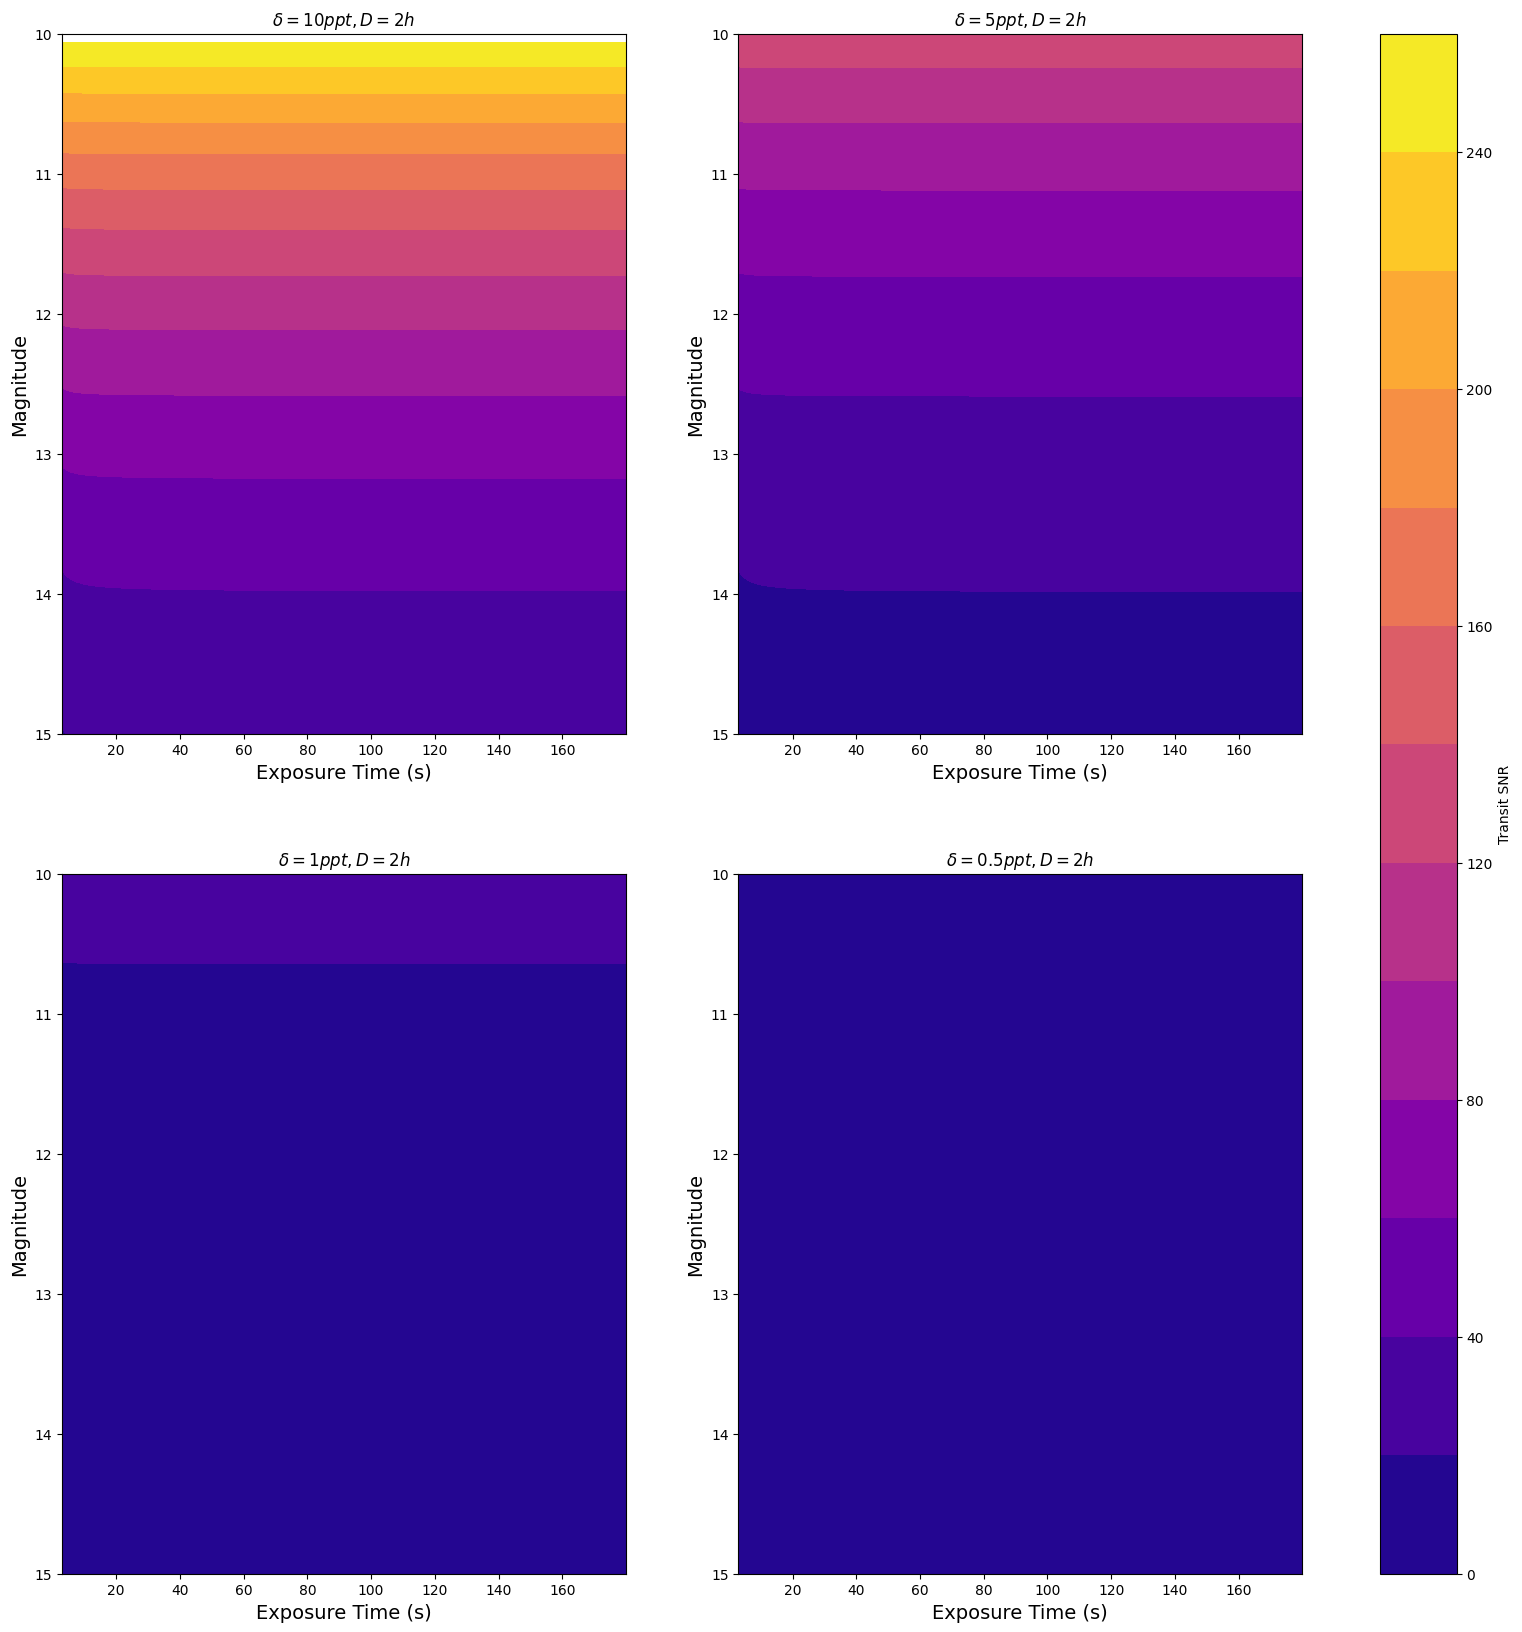

In [10]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

maxsnr = np.max([snr_vec_10ppt,snr_vec_05ppt, snr_vec_1ppt, snr_vec_5ppt])
#minsnr = np.min(snr_vec_05ppt)
#norm = colors.Normalize(vmin=0, vmax=maxsnr)

colour_levels = np.arange(0, maxsnr, 20)

im = ax[0,0].contourf(X, Y, snr_vec_10ppt, cmap='plasma', levels = colour_levels)
ax[0,0].set_title('$ \delta = 10 ppt, D = 2 h $')

ax[1,0].contourf(X, Y, snr_vec_1ppt, cmap='plasma', levels = colour_levels)
ax[1,0].set_title('$ \delta = 1 ppt, D = 2 h $')

ax[0,1].contourf(X,Y, snr_vec_5ppt, cmap='plasma', levels = colour_levels)
ax[0,1].set_title('$ \delta = 5 ppt, D = 2 h $')

ax[1,1].contourf(X,Y, snr_vec_05ppt, cmap='plasma', levels = colour_levels)
ax[1,1].set_title('$ \delta = 0.5 ppt, D = 2 h $')


for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('Magnitude', fontsize = 14)
        ax[i,j].set_xlabel('Exposure Time (s)', fontsize = 14)
        ax[i,j].set_ylim(15,10)
        

#fig.subplots_adjust(right=0.8)
fig.colorbar(im, ax=ax, label = 'Transit SNR')
#fig.suptitle('Harlingten 50cm - Transit SNR', fontsize = 14, fontweight = 'bold')
plt.savefig('TransitSNR_MagExp')
#plt.tight_layout()

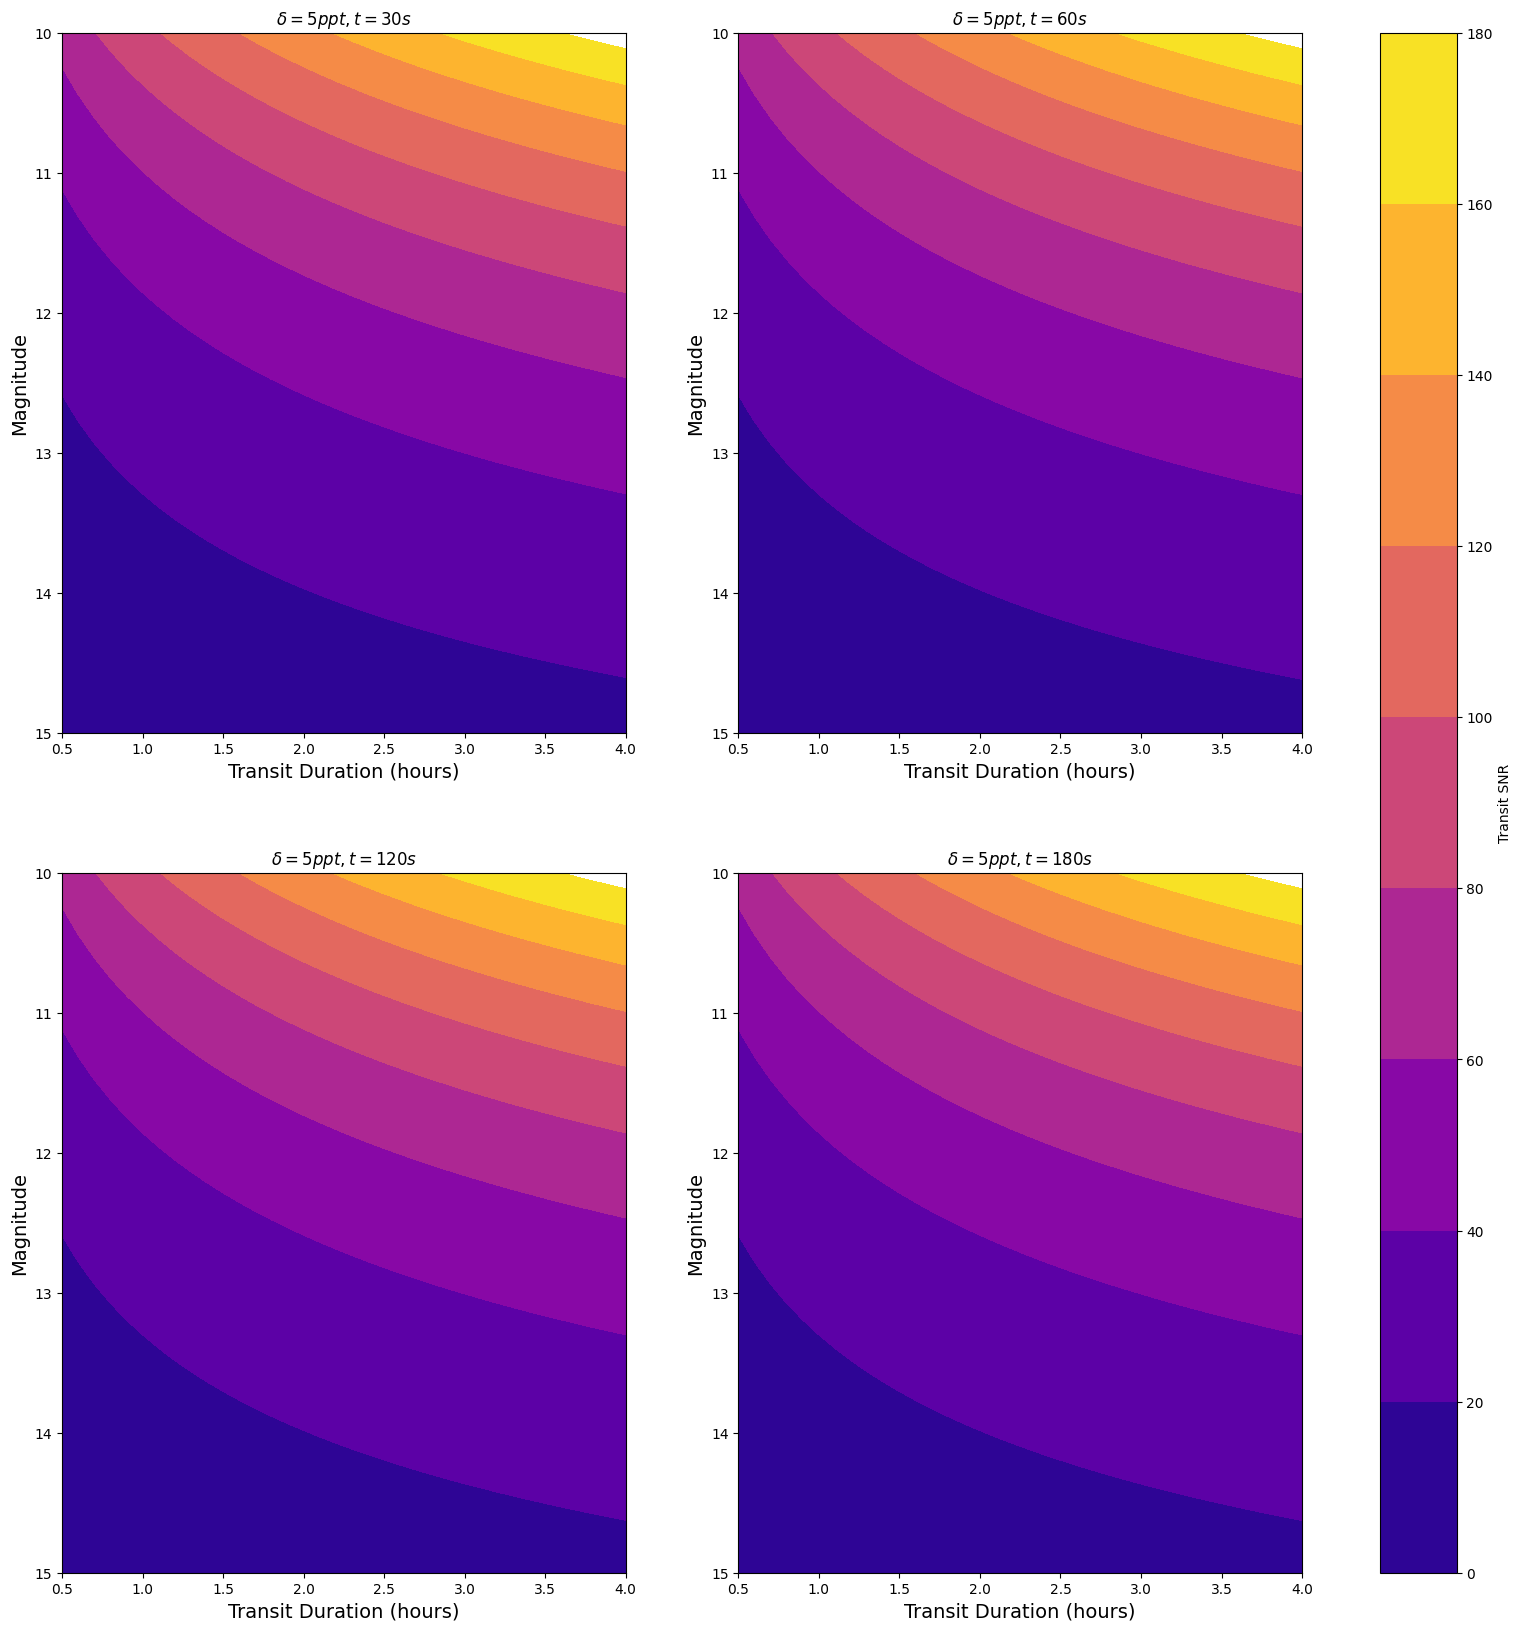

In [11]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

maxsnr = np.max([snr_vec_30s,snr_vec_60s, snr_vec_120s, snr_vec_180s])
colour_levels = np.arange(0, maxsnr, 20)


ax[0,0].contourf(X2, Y2, snr_vec_30s, cmap='plasma', levels = colour_levels)
ax[0,0].set_title('$ \delta = 5 ppt , t = 30 s $')

im = ax[0,1].contourf(X2, Y2, snr_vec_60s, cmap='plasma', levels = colour_levels)
ax[0,1].set_title('$ \delta = 5 ppt , t = 60 s $')

ax[1,0].contourf(X2,Y2, snr_vec_120s, cmap='plasma', levels = colour_levels)
ax[1,0].set_title('$ \delta = 5 ppt , t = 120 s $')

ax[1,1].contourf(X2,Y2, snr_vec_180s, cmap='plasma', levels = colour_levels)
ax[1,1].set_title('$ \delta = 5 ppt , t = 180 s $')

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('Magnitude', fontsize = 14)
        ax[i,j].set_xlabel('Transit Duration (hours)', fontsize = 14)
        ax[i,j].set_ylim(15,10)
        
#fig.subplots_adjust(right=0.8)
fig.colorbar(im, ax=ax, label = 'Transit SNR')
#fig.suptitle('Harlingten 50cm - Transit SNR', fontsize = 14, fontweight = 'bold')
plt.savefig('TransitSNR_MagDur')

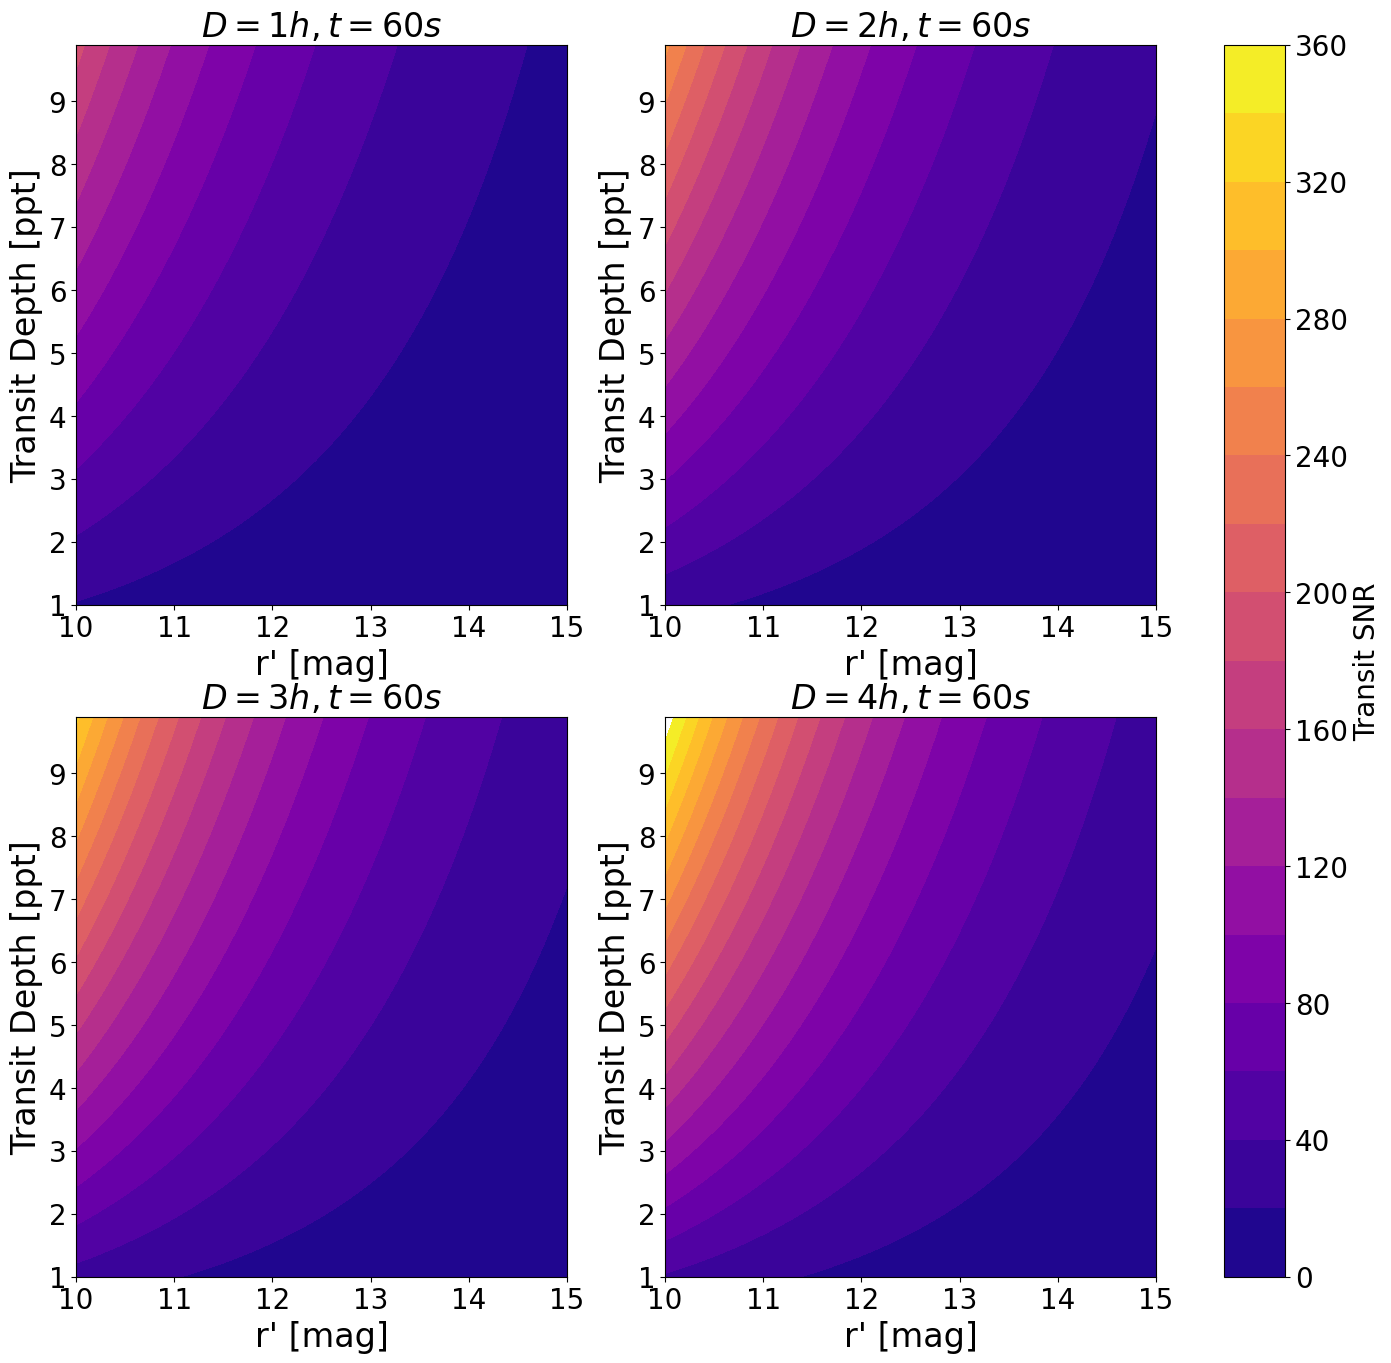

In [12]:
fig, ax = plt.subplots(2,2, figsize=(20,16))

maxsnr = np.max([snr_vec_1h,snr_vec_2h, snr_vec_3h, snr_vec_4h])

color_levels = np.arange(0, maxsnr, 20)

ax[0,0].contourf(X3, Y3*1000, snr_vec_1h, cmap='plasma', levels = color_levels)
ax[0,0].set_title('$ D = 1 h, t = 60 s$', fontsize = 24, fontweight = 'bold')

ax[0,1].contourf(X3, Y3*1000, snr_vec_2h, cmap='plasma', levels = color_levels)
ax[0,1].set_title('$ D = 2 h, t = 60 s$', fontsize = 24, fontweight = 'bold')

ax[1,0].contourf(X3,Y3*1000, snr_vec_3h,cmap='plasma', levels = color_levels)
ax[1,0].set_title('$ D = 3 h, t = 60 s$', fontsize = 24, fontweight = 'bold')

im = ax[1,1].contourf(X3,Y3*1000, snr_vec_4h, cmap='plasma', levels = color_levels)
ax[1,1].set_title('$ D = 4 h, t = 60 s$', fontsize = 24, fontweight = 'bold')


for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("r' [mag]", fontsize = 24)
        ax[i,j].set_ylabel('Transit Depth [ppt]', fontsize = 24)
        ax[i,j].tick_params(axis='both', labelsize = 20)

fig.subplots_adjust(right=0.8)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_ticks(np.arange(0, maxsnr, 40))
cbar.set_label('Transit SNR', fontsize = 20)
#fig.suptitle('Harlingten 50cm - Transit SNR', fontsize = 20, fontweight = 'bold')
plt.savefig('TransitSNR_DepthMag')

#plt.tight_layout()